There are SIRs and co. for this. I will test it with physics informed model. Some

$S(t)= -S(t)\alpha I(t) + \beta D(t) + \gamma A(t) + \delta R(t)$


1. $S(t)$: Susceptible
2. $I(t)$: Infectious
3. $D(t)$: Diagnosed
4. $H(t)$: Healing
5. $A(t)$: Ailing
6. $E(t)$: Extinct
7. $T(t)$: Threatened
8. $R(t)$: Recognized

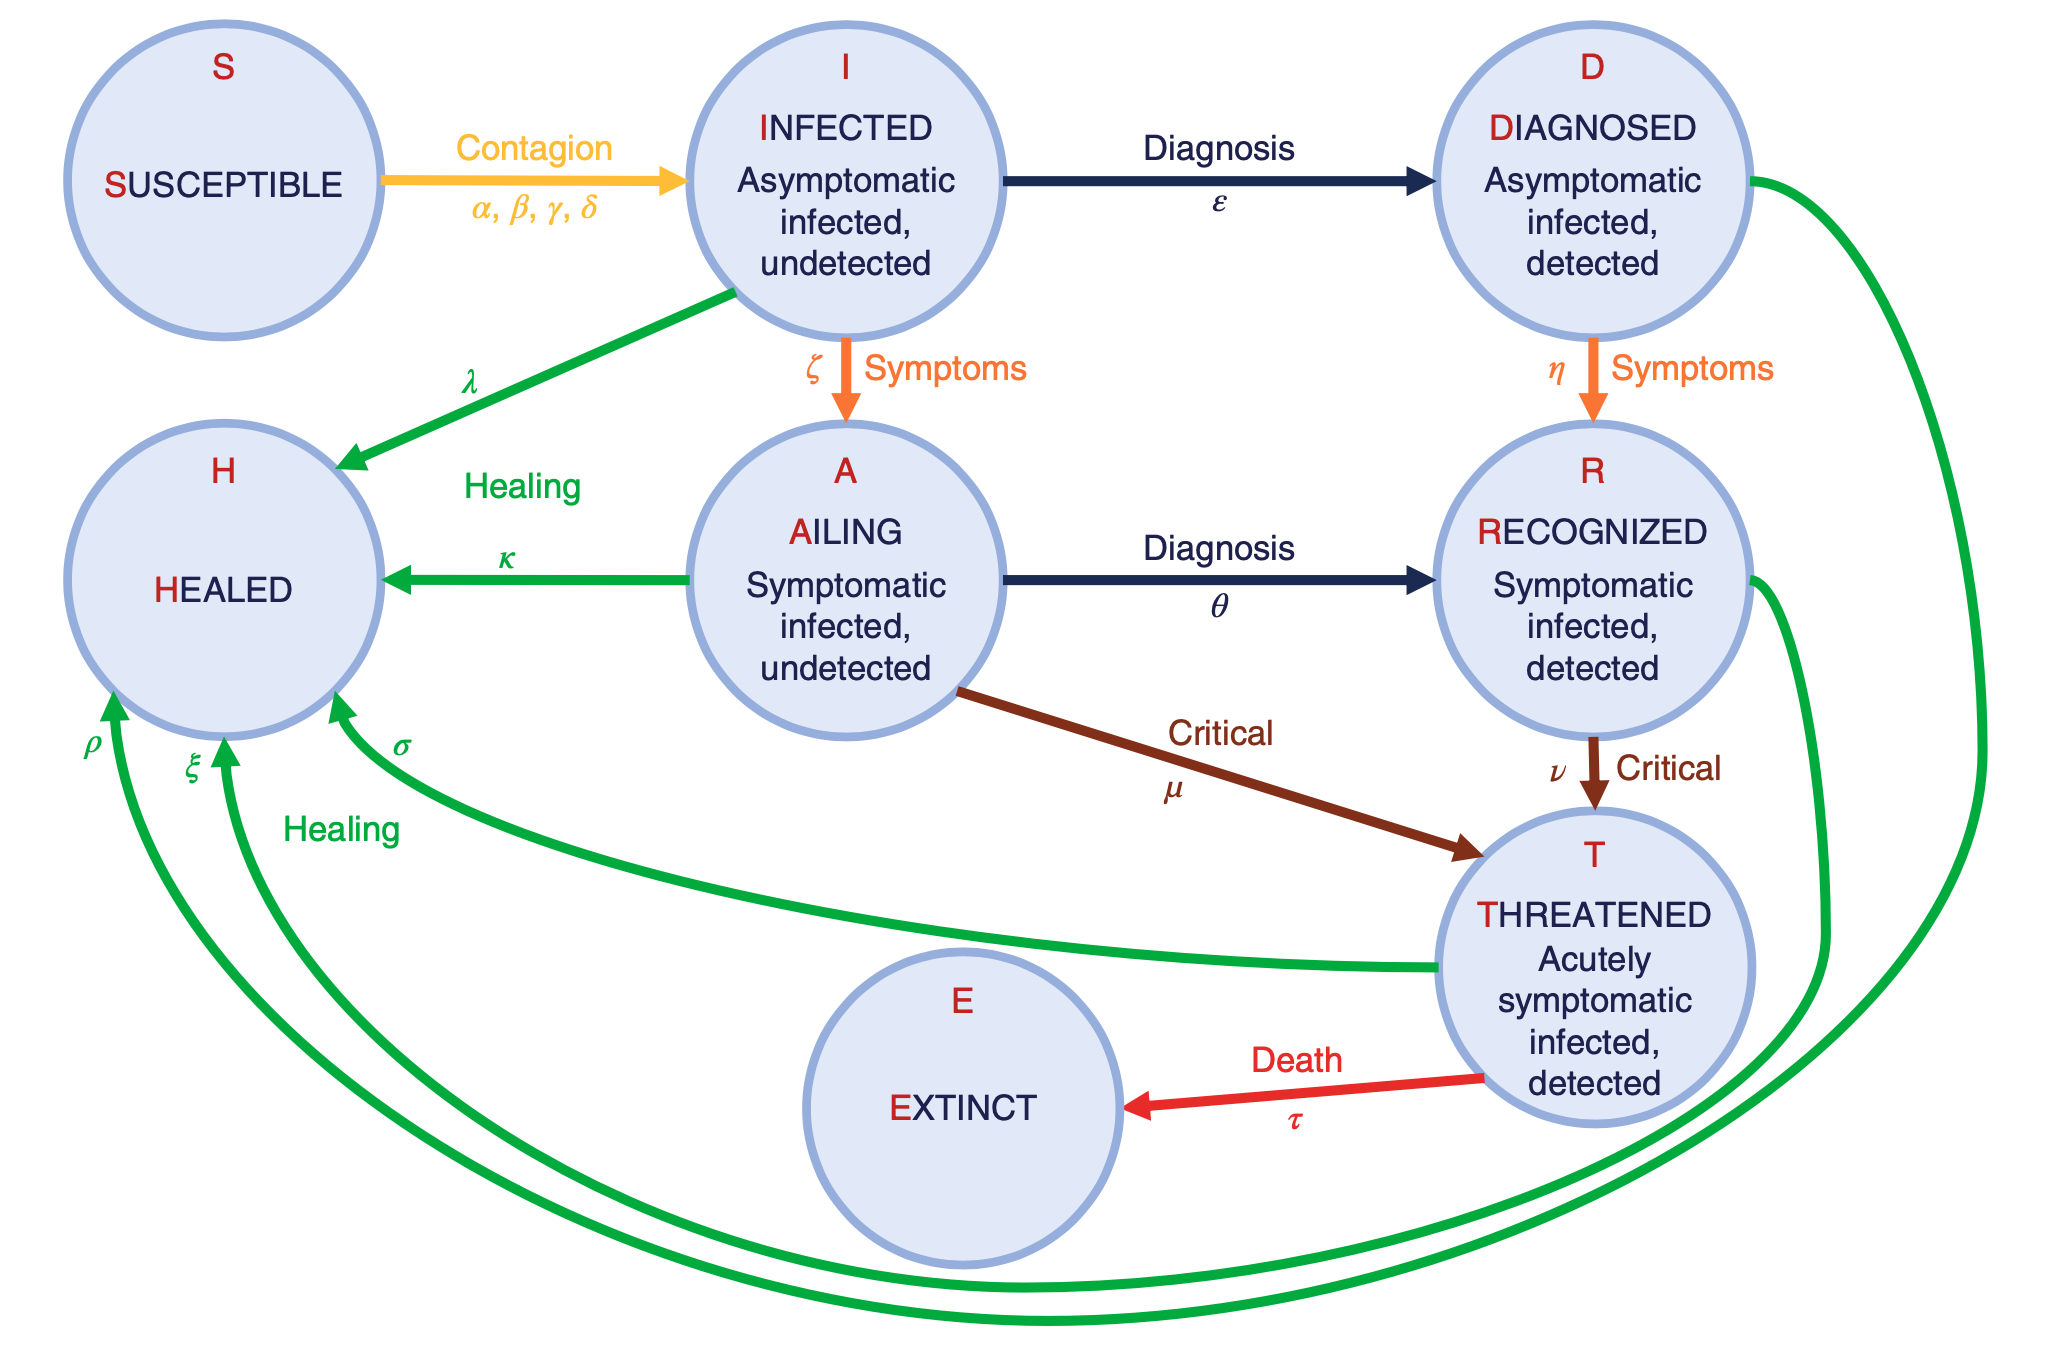

To estimate:

$\alpha, \beta\, \gamma, \delta$


----
SUEIR
Unobserved:
- Susceptible: Potentially have diesase
- Exposed: Incubation period,  during which individuals who have been exposed to the virus may not be as contagious as the infectious individuals. **NOTE**: Not in the SIDARTHA model because there is infected individuals can transmit the virus at an early, preclinical stage of the disease
(https://doi.org/10.1093/ https://doi.org/10.1016/s0140-6736(20)30528-6 https://doi.org/10.1056/nejmc2001468
https://doi.org/10.15585/mmwr.mm6913e1)
- Unreport recovered

Observed:
- Infected
- Recover
- Death

----
SIDARTHA
Unobeserved: 
- Susceptible
Observed: 
- Infected, Healing, Extinct

Exposed (E) models the incubation period, Infected (I) denotes the infectious who currently have the disease, and Re- moved/Recovered (R)

Covid 19 control theory

## Set up

- Recovery data, and hence, active data to be discountinued after 4th August 2021. (https://github.com/CSSEGISandData/COVID-19/issues/4465)
- We will only use data before that date, to get the most data to feed to the model
- The first cases of Covid in Canada, according to the data, are on 28 Jan 2020

In [1]:
from datetime import datetime
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
def filename_to_datetime(filename):
    return datetime.strptime(Path(filename).stem, '%m-%d-%Y')

In [3]:
def last_update_todatetime(df, column='Last_Update'):
    try:
        return pd.to_datetime(df[column], format="%Y-%m-%d %H:%M:%S")
    except ValueError:
        try:
            return pd.to_datetime(df[column], format="%m/%d/%Y %H:%M")
        except ValueError:
            try:
                return pd.to_datetime(df[column], format="%Y-%m-%dT%H:%M:%S")     
            except ValueError:
                return pd.to_datetime(df[column], format="%m/%d/%y %H:%M")

In [22]:
import os
import pandas as pd
from pathlib import PosixPath

direc = os.path.join("COVID-19-master", "csse_covid_19_data", "csse_covid_19_daily_reports") # Directory that contains daily report csv files.
list_csv = sorted(list(PosixPath(direc).glob('*.csv')), key=filename_to_datetime)
canada = []
for file in list_csv:
    if filename_to_datetime(file) <= datetime(month=8, day=4, year=2021) and \
       filename_to_datetime(file) >= datetime(month=1, day=28, year=2020) :
        sample = pd.read_csv(file)
        if "Country/Region" in sample.columns:
            sample = sample.rename({"Country/Region": "Country_Region", "Province/State": "Province_State", "Last Update": "Last_Update"}, axis=1)
        sample = sample[sample["Country_Region"] == "Canada"]
        total_sample = sample[["Confirmed", "Recovered", "Deaths"]].sum()
        for non_state in ['Diamond Princess', 'Grand Princess', 'Repatriated Travellers']:
            if non_state in sample.index:
                sample = sample.drop(non_state)
        sample = sample.fillna(0)
        total_sample['Last_Update'] = last_update_todatetime(sample, 'Last_Update').max()
        canada.append(total_sample)
        
canada=pd.DataFrame(canada)
#canada = pd.concat(canada, axis=1, join='inner')
#canada_data = canada.values.reshape(56,-1,3)
#canada_data[canada_data!=canada_data] = 0

#####################################################################################
# Normalize by total population of each state
# population = pd.read_csv(".../ode_nn/population_states.csv", index_col=0)
# scaler = population.loc[canada.index].values.reshape(56, 1, 1)*1e6
# canada_data = canada_data/scaler
# canada_data = torch.from_numpy(canada_data).float().to(device)

# Mobility Data: beta = 1 - stay_at_home_percentages
# beta = torch.load(".../ode_nn/mobility/canada_beta.pt").float()

# U.S states 1-0 Adjacency Matrix
# graph = torch.load(".../ode_nn/mobility/canada_graph.pt").float()

In [23]:
canada

Confirmed  Recovered   Deaths         Last_Update
0          4.0        0.0      0.0 2020-01-28 23:00:00
1          4.0        0.0      0.0 2020-01-29 19:30:00
2          4.0        0.0      0.0 2020-01-30 16:00:00
3          4.0        0.0      0.0 2020-01-31 23:59:00
4          4.0        0.0      0.0 2020-02-01 18:12:00
..         ...        ...      ...                 ...
550  1434967.0  1404107.0  26599.0 2021-08-01 04:21:50
551  1435347.0  1404244.0  26601.0 2021-08-02 04:21:36
552  1435683.0  1404327.0  26602.0 2021-08-03 04:21:39
553  1437713.0  1405529.0  26608.0 2021-08-04 04:21:25
554  1438806.0  1405971.0  26619.0 2021-08-05 04:21:51

[555 rows x 4 columns]

## Split to confirmed, recovered, death separate files

In [25]:
canada.to_csv('canada.csv', index=False)